#  Evasion Defenses - Adversarial Training

In [1]:
import numpy as np
import tensorflow as tf
import art
from art.estimators.classification import TensorFlowV2Classifier
print(f'Tensorflow version {tf.__version__}')
print(f'ART Version {art.__version__}')
import sys
sys.path.append('../lib')
import utils
from utils import load_preprocess

2024-06-12 15:57:33.989200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 15:57:33.989229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 15:57:33.990322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.15.1
ART Version 1.17.1


In [2]:
# Load the pre-trained ResNet50V2 model
model = tf.keras.applications.ResNet50V2(weights='imagenet')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [3]:

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# Wrap the model with ART's TensorFlowV2Classifier
wrapper = TensorFlowV2Classifier(model=model, nb_classes=1000, input_shape=(224, 224, 3), clip_values=(0, 255), loss_object=loss_object)

In [4]:
from art.attacks.evasion import FastGradientMethod
plane1 = load_preprocess('../images/plane1.jpg')
plane2 = load_preprocess('../images/plane2.jpg')
plane3 = load_preprocess('../images/plane3.jpg')
# combine planes into a train dataset
# load_preprocess returns the image and the batch number, and we only need the image, ie plane[0]
x_train = np.array([plane2[0],plane3[0]])
y_train_labels = np.array([404, 404])

# Hot encode  labels
num_classes = 1000  # Assuming your model output layer has 1000 classes
y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes=num_classes)

In [5]:
# Adversarial Training Example
# Generate adversarial training data
attack = FastGradientMethod(estimator=wrapper, eps=0.1)
x_train_adv = attack.generate(x=x_train)
x_train_adv.shape

(2, 224, 224, 3)

In [6]:
# Combine original and adversarial examples
x_train_combined = np.concatenate((x_train, x_train_adv), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)
x_train_combined.shape, y_train_combined.shape

((4, 224, 224, 3), (4, 1000))

In [7]:
utils.model = model
utils.predictions(x_train_combined)

1/1 [==============================] - 1s 565ms/step


[[('n04592741', 'wing', 0.85083425)],
 [('n02690373', 'airliner', 0.8452497)],
 [('n01737021', 'water_snake', 0.5592953)],
 [('n02692877', 'airship', 0.9995758)]]

In [8]:
test_plane=plane1
utils.predictions(test_plane)

1/1 [==============================] - 0s 200ms/step


[[('n02690373', 'airliner', 0.94252676)]]

##### Create an adversarial test image using he fsgm attack. It gets misclassified as a warplane or space shuttle

In [9]:
adv_plane = attack.generate(x=test_plane)
utils.predictions(adv_plane)

1/1 [==============================] - 0s 17ms/step


[[('n04266014', 'space_shuttle', 0.9215292)]]

##### Do the adversarial trainining with the combined training dataset

In [10]:
# Train the model on the combined dataset
model.fit(x_train_combined, y_train_combined, batch_size=1, epochs=10)

Epoch 1/10


I0000 00:00:1718204288.708044  923682 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 14s 27ms/step - loss: 3.6820 - accuracy: 0.7500
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 0.0102 - accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 0s 31ms/step - loss: 2.1240e-04 - accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s 20ms/step - loss: 2.6524e-05 - accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s 26ms/step - loss: 7.1823e-06 - accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 21ms/step - loss: 2.8908e-06 - accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 23ms/step - loss: 1.6689e-06 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 30ms/step - loss: 1.0729e-06 - accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 0s 32ms/step - loss: 8.0466e-07 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 32ms/step - loss: 8.0466e-07 - accuracy: 1.0000


##### Test against the adversarial image.It was previously miss-classified as warplane. After adversarial training is classified correctly as airliner ignoring the perturbation

In [11]:
utils.predictions(adv_plane)

1/1 [==============================] - 0s 14ms/step


[[('n02690373', 'airliner', 0.10703117)]]

##### This is for demostration only. In real life you'd use bigger training and test datasets

## Adversarial Traininig for Patches with ART Adversarial Trainer 

In [23]:
from tensorflow.keras.optimizers import Adam
from art.attacks.evasion import AdversarialPatch  
from art.defences.trainer import AdversarialTrainer 
from tensorflow.keras.losses import CategoricalCrossentropy
# Load model from scratch and setup the ART wrapper
model = tf.keras.applications.ResNet50V2(weights='imagenet')
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
wrapper = TensorFlowV2Classifier(model=model, 
                                 nb_classes=1000, 
                                 input_shape=(224, 224, 3), 
                                 clip_values=(0, 255),
                                 loss_object = CategoricalCrossentropy(),
                                 optimizer=Adam())
# Define the adversarial patch  
patch_attack = AdversarialPatch(classifier=wrapper, max_iter=50)  
# Create the Adversarial Trainer  
# Note the ratio
# it denotes the % of images that be replaced by the adversarial patach
trainer = AdversarialTrainer(wrapper, attacks=patch_attack, ratio=0.5)  
racer_img = load_preprocess('../images/racing-car.jpg')
x_train = np.array([racer_img[0],racer_img[0],racer_img[0],racer_img[0]])
y_train_labels = np.array([751,751,751,751])
# Hot encode  labels
num_classes = 1000  # Assuming your model output layer has 1000 classes
y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes=num_classes)

# Train the model with adversarial examples generated on-the-fly  
trainer.fit(x_train, y_train, nb_epochs=5) 

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
utils.model = model
utils.predict(racer_img)

1/1 [==============================] - 0s 21ms/step


{'label': 751,
 'wordnet_id': 'n04037443',
 'class_name': 'racer',
 'confidence_score': 0.99999964}

In [25]:
mean_b = 103.939
mean_g = 116.779
mean_r = 123.680


image_shape = (224, 224, 3)
clip_values = (0, 255)
batch_size = 16

scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500
tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, 
                             input_shape=image_shape, clip_values=clip_values, nb_classes=1000,
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

In [15]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

target_class = 281  # 'tabby cat' class in ImageNet
y_one_hot = np.zeros(1000)
y_one_hot[target_class] = 1.0
y_target = np.expand_dims(y_one_hot, axis=0)  # Shape (1, 1000)

patch, patch_mask = ap.generate(x=racer_img, y=y_target)

Adversarial Patch TensorFlow v2:   0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
patched_image = ap.apply_patch(racer_img, scale=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


{'label': 751,
 'wordnet_id': 'n04037443',
 'class_name': 'racer',
 'confidence_score': 0.9995757}

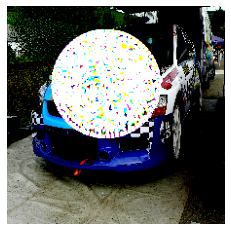

In [35]:
utils.show_image(patched_image[0])
utils.predict(patched_image)

##### The adversarially trained classifier ignores the patch, which we know from our Targeted Adversarial Patch notebook fools the ResNet50v2 classifier. This is a proof of concept to demonstate the techniques. In real life you would use bigger datasets to train the model and evaluate its performance